In [ ]:
%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
#import scrublet as scr
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

In [2]:
#Introduce variables

#name of first object (arbitrary)
data1 = "_Training"
Object1 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/combined_ys_fliv_mouse_111021.h5ad"

#provide categorical containing batch information
batch = "lr_batch"

#Procide PC intervals to study
inte = [1,2,3,4,5,6,7,8,9,10] #thta value

#provide cateorical to join between datasets, this shoould be annotations for cells (obs col)
cat1 = 'corr_concat'

#Use BBKNN or Harmony? 
correction = "Harmony"

#provide an output path and a folder name to be created
output = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/kbet_cross-species/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k/"

## Start of processing module

In [3]:
# Load dataset 1
adata_orig = sc.read(Object1)

In [4]:
#adata_orig.obs["id_lane"] = adata_orig.obs["lanes"].astype(str) + "_" + adata_orig.obs["fetal.ids"].astype(str)

In [5]:
#list(adata_orig.obs["id_lane"].unique())

# Start of predictive and output loop

In [10]:
os.mkdir(output)
os.chdir(output)
print(os.getcwd())

/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/kbet_cross-species/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k


# Dev Notes

Loop to compute umap coords for each harmony loop, the umap coords can be fed into kbet for testing

## To add:
- loop to export umap coords for each theta value as .csv
- Sil score function for each set of umap coords (to plot together with kbet)
- Magic function to compute kbet
- Rand and MI to show that logit regression annotation outcome does not change with change in Harmony theta

# Work-in-progress

In [12]:
#Create output directory
if os.path.exists(output) == True:
    print("Path already exists!")
else:
    os.mkdir(output)

os.chdir('./'+output)
print(os.getcwd())

#Start of the subset and plotting loop

adata = adata_orig[:]

common_cat = "corr_concat" 
adata.obs[common_cat] = adata.obs[cat1].astype(str) + data1

#Get PCA by covarainces of variable genes
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)

#Create a subsample to save on re sampling
grouped = adata.obs.groupby('corr_concat')
df = grouped.apply(lambda x: x.sample(frac=0.4))
df = df.droplevel('corr_concat')
keep = df.index
adata = adata[adata.obs.index.isin(keep)]

#Get control PCA, snn and umap coord without harmony:
#sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
#sc.pp.neighbors(adata,n_neighbors=15, n_pcs=50)
#sc.tl.umap(adata)

#make a copy
adata_loop_start = adata[:]

#Create a dataframe holder for umap coords
temp_umap = pd.DataFrame(adata.obsm["X_umap"])
temp_umap.columns=["X_umap1","X_umap2"]
temp_umap["batch"] = list(adata.obs[batch])
temp_umap["clusters"] = list(adata.obs[cat1])

map_name = ("control_no_batch")
temp_umap.to_csv(map_name+'.csv')


adata = adata_loop_start[:]
for i in inte:
#Batch correction
    if (correction == "Harmony"): 
        print("Commencing harmony")
        #Create hm subset
        adata_hm = adata[:]
        #sc.pp.pca(adata_hm, n_comps=50, use_highly_variable=True, svd_solver='arpack')
        #Set harmony variables
        data_mat = np.array(adata_hm.obsm["X_pca"])
        meta_data = adata_hm.obs
        vars_use = [batch]
        #Run Harmony
        ho = hm.run_harmony(data_mat, meta_data, vars_use, theta = i)
        res = (pd.DataFrame(ho.Z_corr)).T
        res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
        #Insert coordinates back into object
        adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
        adata_hm.obsm["X_pca"] = np.array(res)
        #Run neighbours
        sc.pp.neighbors(adata_hm,n_neighbors=15, n_pcs=50)
        adata = adata_hm[:]
        sc.tl.umap(adata)

    else:
        print("Commencing BBKNN")
        sc.pp.pca(adata, n_comps=i, use_highly_variable=False, svd_solver='arpack')
        sc.external.pp.bbknn(adata, batch_key=batch, approx=True, metric='angular', copy=False, n_pcs=i, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=1)
        sc.tl.umap(adata)
        
    #Create a dataframe holder for umap coords
    temp_umap = pd.DataFrame(adata.obsm["X_umap"])
    temp_umap.columns=["X_umap1","X_umap2"]
    temp_umap["batch"] = list(adata.obs[batch])
    temp_umap["clusters"] = list(adata.obs[cat1])

    map_name = ("harmony_theta_"+str(i))
    temp_umap.to_csv(map_name+'.csv')

Trying to set attribute `.obs` of view, copying.


/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/kbet_cross-species/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k
Commencing harmony


2021-10-11 15:37:19,049 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-10-11 15:37:50,535 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-10-11 15:38:22,436 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-10-11 15:38:57,110 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
Commencing harmony


2021-10-11 15:39:43,147 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-10-11 15:40:17,918 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-10-11 15:40:55,437 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-10-11 15:41:17,002 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
Commencing harmony


2021-10-11 15:41:43,715 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-10-11 15:42:22,412 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-10-11 15:43:07,140 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-10-11 15:43:26,042 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
Commencing harmony


2021-10-11 15:43:55,041 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-10-11 15:44:35,025 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-10-11 15:45:12,506 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-10-11 15:45:30,026 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
Commencing harmony


2021-10-11 15:46:01,644 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-10-11 15:46:40,632 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-10-11 15:47:16,402 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-10-11 15:47:39,210 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
Commencing harmony


2021-10-11 15:48:10,704 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-10-11 15:48:50,116 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-10-11 15:49:28,806 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-10-11 15:49:52,619 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2021-10-11 15:50:21,008 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2021-10-11 15:50:43,211 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2021-10-11 15:51:06,505 - harmonypy - INFO - Iteration 7 of 10
Iteration 7 of 10
2021-10-11 15:51:39,516 - harmonypy - INFO - Iteration 8 of 10
Iteration 8 of 10
2021-10-11 15:52:20,400 - harmonypy - INFO - Iteration 9 of 10
Iteration 9 of 10
2021-10-11 15:53:04,306 - harmonypy - INFO - Iteration 10 of 10
Iteration 10 of 10
2021-10-11 15:53:44,816 - harmonypy - INFO - Stopped before convergence
Stopped before convergence


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
Commencing harmony


2021-10-11 15:54:22,501 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-10-11 15:55:09,220 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-10-11 15:55:30,901 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-10-11 15:55:55,112 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
Commencing harmony


2021-10-11 15:56:28,907 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-10-11 15:57:06,305 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-10-11 15:57:42,317 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-10-11 15:58:11,413 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2021-10-11 15:58:41,608 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2021-10-11 15:58:58,315 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2021-10-11 15:59:34,904 - harmonypy - INFO - Iteration 7 of 10
Iteration 7 of 10
2021-10-11 16:00:15,417 - harmonypy - INFO - Iteration 8 of 10
Iteration 8 of 10
2021-10-11 16:00:46,911 - harmonypy - INFO - Converged after 8 iterations
Converged after 8 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
Commencing harmony


2021-10-11 16:01:21,927 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-10-11 16:02:01,007 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-10-11 16:02:25,116 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-10-11 16:02:53,010 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
Commencing harmony


2021-10-11 16:03:28,501 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-10-11 16:04:12,312 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-10-11 16:04:55,402 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-10-11 16:05:36,908 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


# Compute sil score for each set of umap coords

In [24]:
outpath

'./kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k/sil_scores'

In [26]:
# Read files from directory
from sklearn.metrics import silhouette_score

relevant_path = output
included_extensions = ['.csv']

#provide an output path and a folder name to be created
output_dir = "sil_scores"


outpath = relevant_path + output_dir
if os.path.exists(outpath) == True:
    print("Path already exists!")
else:
    os.mkdir(outpath)
file_names = [fn for fn in os.listdir(relevant_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

#Create append lists
name_ls = []
sil = []

for i in (file_names):
    map = pd.read_csv(relevant_path+i,index_col = 0)
    points = map.iloc[:,0:2]
    labels = map["batch"]
    sil.append(silhouette_score(points, labels, metric = 'euclidean'))
    name = i.replace("harmony_","")
    name = name.replace(".csv","")
    name_ls.append(name)

#combine both lists
append = pd.DataFrame(list(zip(sil, name_ls)))
append.columns = ["sil","var"]
append.to_csv(outpath +"/sil_score_appended.csv")

In [27]:
append

,sil,var
0,-0.201495,theta_9
1,-0.169710,theta_1
2,-0.223098,theta_6
3,-0.159208,theta_4
4,-0.174679,theta_2
5,-0.204124,theta_8
6,-0.199403,theta_10
7,-0.173042,theta_3
8,-0.240162,theta_7
9,-0.210665,control_no_batch


In [4]:
output

'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/kbet_cross-species/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k/'

# Run R script for kbet calculation

In [ ]:
! Rscript /nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/kbet_cross-species/2_kbet_R_increased_batch.r $output

Loading required package: usethis
Skipping install of 'kBET' from a github remote, the SHA1 (4c9dafab) has not changed since last install.
  Use `force = TRUE` to force installation
[1] "control_no_batch.csv"
[1] "ExE ectoderm_mouse_gastrulation_Training"
Initial neighbourhood size is set to 588.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.649   0.044   0.694 
KNN input is a list, extracting nearest neighbour index.
Number of kBET tests is set to 236.
No outsiders found.[1] "ExE endoderm_mouse_gastrulation_Training"
Initial neighbourhood size is set to 467.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.364   0.008   0.372 
KNN input is a list, extracting nearest neighbour index.
Number of kBET tests is set to 187.
[1] "Visceral endoderm_mouse_gastrulation_Training"
Initial neighbourhood size is set to 64.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elap

# Plot Kbet

In [60]:
%matplotlib inline
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

import gc
import os
import re

In [27]:
directory = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/kbet_cross-species/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k/kbet_scores"
tables = os.listdir(directory)
tables = [x for x in tables if x.endswith('.csv') and not x.startswith("concatenated")]
tables

['avg_kbet_score_concat.csv',
 'harmony_theta_1_kbet_scores.csv',
 'harmony_theta_2_kbet_scores.csv',
 'control_no_batch_kbet_scores.csv',
 'harmony_theta_8_kbet_scores.csv',
 'harmony_theta_4_kbet_scores.csv',
 'harmony_theta_7_kbet_scores.csv',
 'harmony_theta_9_kbet_scores.csv',
 'harmony_theta_3_kbet_scores.csv',
 'harmony_theta_6_kbet_scores.csv',
 'harmony_theta_5_kbet_scores.csv',
 'harmony_theta_10_kbet_scores.csv']

In [28]:
#name = "./concatenated_scores_minus_PCs.csv"
#file = pd.read_csv(name)
#file = file.drop([0])
read_list_order = [
'control_no_batch_kbet_scores.csv',
'harmony_theta_1_kbet_scores.csv',
 'harmony_theta_2_kbet_scores.csv',
 'harmony_theta_3_kbet_scores.csv',
 'harmony_theta_4_kbet_scores.csv',
 'harmony_theta_5_kbet_scores.csv',
 'harmony_theta_6_kbet_scores.csv',
 'harmony_theta_7_kbet_scores.csv',
 'harmony_theta_8_kbet_scores.csv',
 'harmony_theta_9_kbet_scores.csv',]

In [29]:
names = list()
kbet_scores = list()
for i in read_list_order :
    print(i)
    file = pd.read_csv(directory+"/"+i,index_col=0)
    #Extract kbet score
    test_name = i.replace("_kbet_scores.csv","")
    test_name = test_name.replace("_no_batch","")
    test_name = test_name.replace("harmony_","")
    test_name = test_name.replace("_","=")
    temp_kbet = (file['kbet'][file.iloc[:,0].isin(["avg_kbet"])]).values[0]
    names.append(test_name)
    kbet_scores.append(temp_kbet)
    
kbet_out = pd.DataFrame({'test': names,'kbet_score': kbet_scores })
kbet_out.to_csv(directory+"/"+"avg_kbet_score_concat.csv")

control_no_batch_kbet_scores.csv
harmony_theta_1_kbet_scores.csv
harmony_theta_2_kbet_scores.csv
harmony_theta_3_kbet_scores.csv
harmony_theta_4_kbet_scores.csv
harmony_theta_5_kbet_scores.csv
harmony_theta_6_kbet_scores.csv
harmony_theta_7_kbet_scores.csv
harmony_theta_8_kbet_scores.csv
harmony_theta_9_kbet_scores.csv


In [35]:
kbet_out

,test,kbet_score
0,control,0.471955
1,theta=1,0.415127
2,theta=2,0.410712
3,theta=3,0.454836
4,theta=4,0.439770
5,theta=5,0.392563
6,theta=6,0.477272
7,theta=7,0.491624
8,theta=8,0.512968
9,theta=9,0.487144


In [30]:
#Read sil scores
sil = pd.read_csv("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/kbet_cross-species/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k/sil_scores/sil_score_appended.csv",index_col = 0)
sil = sil.sort_values(by=['var'])

#redorder = 
sil.iloc[:,0]

9    -0.210665
1    -0.169710
6    -0.199403
4    -0.174679
7    -0.173042
3    -0.159208
10   -0.178629
2    -0.223098
8    -0.240162
5    -0.204124
0    -0.201495
Name: sil, dtype: float64

In [31]:
sil = sil[~sil['var'].isin(['theta_10'])]

In [32]:
kbet_out

,test,kbet_score
0,control,0.471955
1,theta=1,0.415127
2,theta=2,0.410712
3,theta=3,0.454836
4,theta=4,0.439770
5,theta=5,0.392563
6,theta=6,0.477272
7,theta=7,0.491624
8,theta=8,0.512968
9,theta=9,0.487144


# Rand and MI

In [45]:
directory = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/kbet_cross-species/kbet_loop_out_harmony_theta_var_v3_increase_batch_increased_k/"
tables = os.listdir(directory)
tables = [x for x in tables if x.endswith('.csv') and not x.startswith("concatenated")]
read_list_order = sorted(tables)

['control_no_batch.csv',
 'harmony_theta_1.csv',
 'harmony_theta_10.csv',
 'harmony_theta_2.csv',
 'harmony_theta_3.csv',
 'harmony_theta_4.csv',
 'harmony_theta_5.csv',
 'harmony_theta_6.csv',
 'harmony_theta_7.csv',
 'harmony_theta_8.csv',
 'harmony_theta_9.csv']

In [62]:
define_control = 'control_no_batch.csv'
control = pd.read_csv(directory+"/"+define_control,index_col=0)

names = list()
kbet_scores = list()
for i in read_list_order :
    print(i)
    file = pd.read_csv(directory+"/"+i,index_col=0)
    rand = adjusted_rand_score(list(control['clusters']), list(file['clusters']))
    mi=sklearn.metrics.adjusted_mutual_info_score(list(control['clusters']), list(file['clusters']), average_method='arithmetic')

control_no_batch.csv
harmony_theta_1.csv
harmony_theta_10.csv
harmony_theta_2.csv
harmony_theta_3.csv
harmony_theta_4.csv
harmony_theta_5.csv
harmony_theta_6.csv
harmony_theta_7.csv
harmony_theta_8.csv
harmony_theta_9.csv


In [ ]:
 print(i)
    file = pd.read_csv(directory+"/"+i,index_col=0)
    #Extract kbet score
    test_name = i.replace("_kbet_scores.csv","")
    test_name = test_name.replace("_no_batch","")
    test_name = test_name.replace("harmony_","")
    test_name = test_name.replace("_","=")
    temp_kbet = (file['kbet'][file.iloc[:,0].isin(["avg_kbet"])]).values[0]
    names.append(test_name)
    kbet_scores.append(temp_kbet)
    
kbet_out = pd.DataFrame({'test': names,'kbet_score': kbet_scores })
kbet_out.to_csv(directory+"/"+"avg_kbet_score_concat.csv")

NameError: name 'rand_x' is not defined

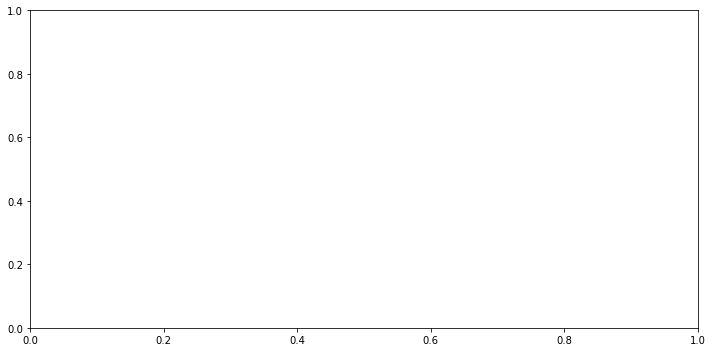

In [33]:
ig,ax = plt.subplots(figsize = (10,5))
# make a plot
ax.plot(rand_x, rand_y, 'bx-', color="blue")
# set x-axis label
ax.set_xlabel("Harmony theta value",fontsize=12)
# set y-axis label
rand_label = "adj_Rand_Index: mean="+str(mean_rand) + " SD=" + str(sd_rand)
ax.set_ylabel(rand_label,color="blue",fontsize=14)
# make a plot with different y-axis using second axis object
ax2=ax.twinx()
ax2.plot(mi_x, mi_y, 'bx-',color="red")
mi_label = "Mutual Information score: mean="+str(mean_mi) + " SD=" + str(sd_mi)
ax2.set_ylabel(mi_label,color="red",fontsize=12)
plt.title('Effect of different Harmony theta on celltype classification')
plt.savefig("./Harmony_theta_effect.pdf",dpi=200)
#Set X ticks to integer values
plt.xticks(np.arange(min(rand_x), (max(rand_x)+1), 1.0))
plt.show();

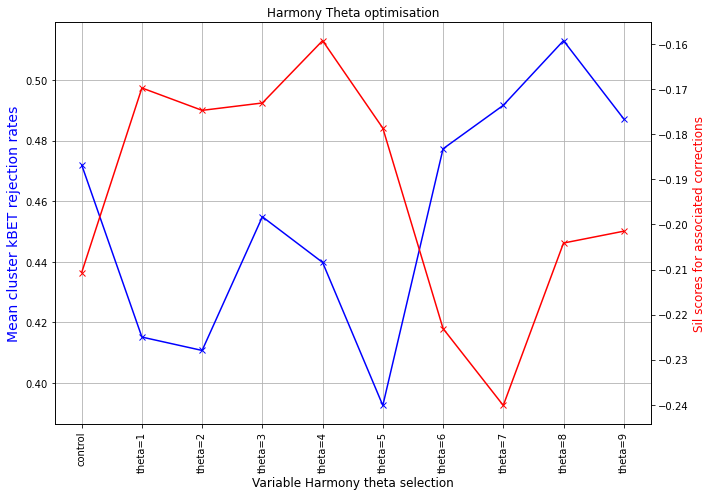

In [34]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

x = kbet_out.iloc[:,0]
y= kbet_out.iloc[:,1]

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (10,7))
# make a plot
ax.plot(x, y, 'bx-', color="blue")
ax.grid()
# set x-axis label
ax.set_xlabel("Variable Harmony theta selection",fontsize=12)
plt.xticks(rotation=90)

# set y-axis label
rand_label = "Mean cluster kBET rejection rates"
ax.set_ylabel(rand_label,color="blue",fontsize=14)

# make a plot with different y-axis using second axis object
ax2=ax.twinx()
ax2.plot(x, sil.iloc[:,0], 'bx-',color="red")
mi_label = "Sil scores for associated corrections"
ax2.set_ylabel(mi_label,color="red",fontsize=12)



plt.title('Harmony Theta optimisation')
plt.savefig("./kbet_harmony_theta.pdf",dpi=200)
#Set X ticks to integer values
plt.show();